Install this stuff first:

```
install.packages("scrm")
install.packages("https://github.com/YingZhou001/popdemog/raw/master/POPdemog_1.1.tar.gz", repos=NULL)
install.packages("tidyverse")
install.packages("glue")
```

In [1]:
library(scrm)
library(POPdemog)
library(tidyverse)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



### Set the coalescent parameters

In [2]:
scale_time <- function(t) { t / gen_time / (4 * Ne0) }
scale_Ne <- function(Ne) { Ne / Ne0 }
scale_migr <- function(m) { 4 * m * Ne0 }

In [3]:
# generation time
gen_time <- 25

# effective population size used for scaling below
Ne0 <- 20000

# how old are the sampled Neanderthal haplotypes?
T_nea_age <- 70000

# how many haplotypes to sample from each population?
n_afr <- 200
n_eur <- 100
n_nea <- 4
n_chimp <- 1

n_haplotypes <- 100000
hap_length <- 5001

# split between Homo and Chimp
T_chimp_split <- 6000000
# split between MH and Neanderthals
T_nea_mh_split <- 600000
# African/non-African split and bottleneck
T_afr_nonafr_split <- 70000

# Ne during the Out of Africa bottleneck
Ne_bottleneck <- 2000

# size of the Neanderthal population
Ne_nea <- 1000

# size of the ancestral population
Ne_anc <- 10000

# EUR <-> AFR migration rates
m_afr_bottle <- 15e-5
m_afr_eur <- 2.5e-5
T_m_afr_eur <- 15000

# Neanderthal introgression parameters
T_nea_admix_start <- 55000
T_nea_admix_end <- T_nea_admix_start - 1000
m_nea_admix <- 0.00075

# mutation rate per site per generation
mut_rate <- 2.5e-8
# probability of cross-over between adjacent bases per generation 
recomb_rate <- 1e-8

# population scaled mutation and recombination rates
theta <- 4 * Ne0 * mut_rate * hap_length
rho <- 4 * Ne0 * recomb_rate * hap_length

In [4]:
n_haplotypes * hap_length / 3e6

[1] 166.7

Generate the command line options for time-sampling (4 Neanderthal haplotypes at 70ky ago and a single EMH haplotype at different time points specified from the Ice Age paper):

In [5]:
emh_ages <- read_delim("../data/emh_ages.txt", col_types="ci", col_names=c("name", "age"), delim=" ") %>%
    filter(name != "Oase1") %>%
    mutate(name=paste0("emh_", 1:nrow(.)))

In [6]:
ages <- bind_rows(emh_ages, tibble(name=paste0("eur_", 1:n_eur), age=0)) # add the "fake" present-day Europeans

In [7]:
eI <- c(
  glue("-eI {scale_time(T_nea_age)}             0        0       {n_nea}    0"), # Neanderthals
  glue("-eI {map_dbl(emh_ages$age, scale_time)} 0        1       0          0"), # EMHs
  glue("-eI 0                                   {n_afr}  0       0          0"), # present-day Africans
  glue("-eI 0                                   0        {n_eur} 0          0"), # present-day Europeans
  glue("-eI 0                                   0        0       0  {n_chimp}")  # present-day chimp
) %>%
  paste(collapse=" ")

### Compose the `scrm` command line string

In [8]:
scrm_cmd <- glue(

"{n_nea + n_afr + n_eur + nrow(emh_ages) + n_chimp} {n_haplotypes} \\
-I 4 0 0 0 0 \\
-r {rho} {hap_length} \\
-t {theta} \\
-n 3 {scale_Ne(Ne_nea)} \\

-em {scale_time(T_nea_admix_end)} 2 3 {scale_migr(m_nea_admix)} \\
-em {scale_time(T_nea_admix_start)} 2 3 0 \\
-en {scale_time(T_nea_admix_start)} 2 {scale_Ne(Ne_bottleneck)} \\

-em 0 1 2 {scale_migr(m_afr_eur)} \\
-em {scale_time(T_m_afr_eur)} 1 2 0 \\

-ej {scale_time(T_afr_nonafr_split)} 2 1 \\
-ej {scale_time(T_nea_mh_split)} 3 1 \\
-ej {scale_time(T_chimp_split)} 4 1 \\

{eI}"

) %>% str_replace_all("\n", " ") %>% str_replace_all("  +", " ")

### Check that the demographic model looks reasonable

There are  7 time events for  4  populations
read N and g, done!
read m, done!
read pos and update, done!
demographic initiation, done!
plot initiation, done!


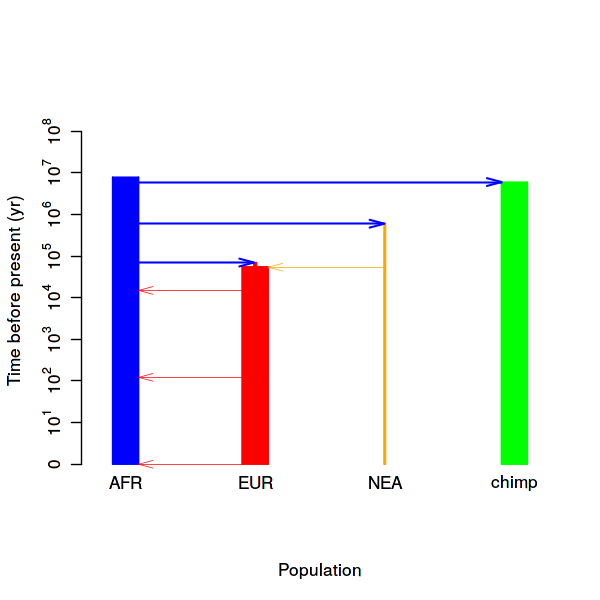

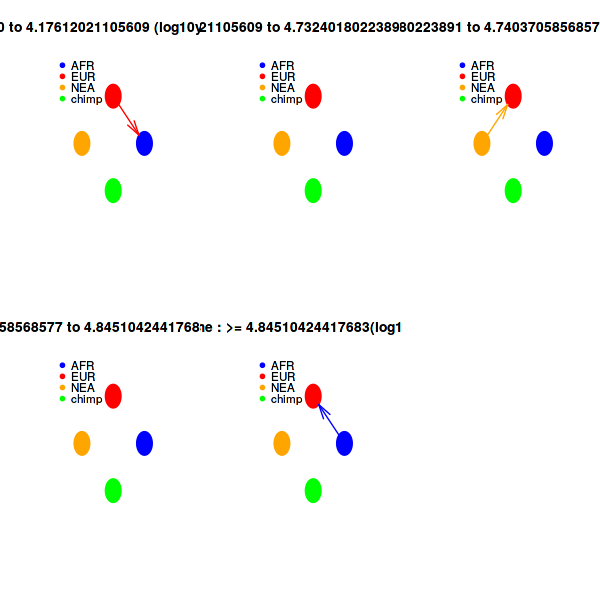

In [9]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=100)

PlotMS(scrm_cmd, type="scrm",
       pops=c("AFR", "EUR", "NEA", "chimp"),
       col.pop=c("blue", "red", "orange", "green"),
       time.scale="log10year", N4=4*Ne0,
       demo.out=TRUE) -> plot_out
PlotMMig(demograph_out=plot_out$demograph_out, mig_par=plot_out$mig_par)

### Run the simulation and extract the matrix with simulated haplotypes

In [10]:
paste("scrm", scrm_cmd)

[1] "scrm 355 1e+05 -I 4 0 0 0 0 -r 4.0008 5001 -t 10.002 -n 3 0.05 -em 0.027 2 3 60 -em 0.0275 2 3 0 -en 0.0275 2 0.1 -em 0 1 2 2 -em 0.0075 1 2 0 -ej 0.035 2 1 -ej 0.3 3 1 -ej 3 4 1 -eI 0.035 0 0 4 0 -eI 0.02251 0 1 0 0 -eI 0.018735 0 1 0 0 -eI 0.0173975 0 1 0 0 -eI 0.01665 0 1 0 0 -eI 0.0164475 0 1 0 0 -eI 0.0162175 0 1 0 0 -eI 0.0162075 0 1 0 0 -eI 0.015485 0 1 0 0 -eI 0.015435 0 1 0 0 -eI 0.015435 0 1 0 0 -eI 0.015435 0 1 0 0 -eI 0.01513 0 1 0 0 -eI 0.015005 0 1 0 0 -eI 0.015005 0 1 0 0 -eI 0.0144875 0 1 0 0 -eI 0.0139875 0 1 0 0 -eI 0.013875 0 1 0 0 -eI 0.01381 0 1 0 0 -eI 0.0137575 0 1 0 0 -eI 0.01316 0 1 0 0 -eI 0.0121525 0 1 0 0 -eI 0.00936 0 1 0 0 -eI 0.008355 0 1 0 0 -eI 0.008355 0 1 0 0 -eI 0.0077325 0 1 0 0 -eI 0.007565 0 1 0 0 -eI 0.0075025 0 1 0 0 -eI 0.00739 0 1 0 0 -eI 0.007335 0 1 0 0 -eI 0.0073075 0 1 0 0 -eI 0.00699 0 1 0 0 -eI 0.0068325 0 1 0 0 -eI 0.0066275 0 1 0 0 -eI 0.00648 0 1 0 0 -eI 0.0058625 0 1 0 0 -eI 0.0054275 0 1 0 0 -eI 0.0050425 0 1 0 0 -eI 0.00495 0 1 0 0 -eI 0.00486 0 1 0 0 -eI 0.0046 0 1 0 0 -eI 0.0041875 0 1 0 0 -eI 0.0041325 0 1 0 0 -eI 0.0041225 0 1 0 0 -eI 0.0041025 0 1 0 0 -eI 0.004025 0 1 0 0 -eI 0.0039075 0 1 0 0 -eI 0.00383 0 1 0 0 -eI 0.0038125 0 1 0 0 -eI 0.0036225 0 1 0 0 -eI 0.00357 0 1 0 0 -eI 0 200 0 0 0 -eI 0 0 100 0 0 -eI 0 0 0 0 1"

In [11]:
sim_res <- scrm(scrm_cmd)

In [12]:
# generate column names for the output df
col_names <- c(paste0("nea_", 1:n_nea),
               emh_ages$name,
               paste0("afr_", 1:n_afr),
               paste0("eur_", 1:n_eur),
               "chimp")

In [13]:
# extract matrices with simulated haplotypes and set the column names
all_sites <- map(sim_res$seg_sites, ~ .x %>% t %>% as_tibble %>% setNames(col_names)) %>% bind_rows

In [14]:
nrow(all_sites)

[1] 14621496

In [15]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,16003415,854.7,60282960,3219.5,75353700,4024.4
Vcells,10464062277,79834.5,24133044461,184120.6,15691030102,119713.1


## Design the archaic admixture array
Keep only those sites that are nearly fixed in Africans, and fixed for a different allele in the Neanderthals (ignore the derived/ancestral state).

**To make testing easier, I'm requiring the African allele to be fixed! This can be changed later.**

In [16]:
# the lowest frequency of an allele allowed in the African population
afr_cutoff <- 1.0

In [17]:
calc_freq <- function(df, pop) {
    df[str_detect(col_names, pop)] %>% rowSums / sum(str_detect(col_names, pop))
}

In [18]:
afr_freq <- calc_freq(all_sites, "afr")
nea_freq <- calc_freq(all_sites, "nea")

In [19]:
admix_array <- filter(all_sites,
                     (afr_freq == 0 | afr_freq >= afr_cutoff) &
                     (nea_freq == 0 | nea_freq == 1) &
                     (abs(afr_freq - nea_freq) > 0.5))

In [20]:
nrow(admix_array)

[1] 504684

What are the observed site patterns in Africans and Neanderthals? There should be only two:

In [21]:
distinct(select(admix_array, starts_with("afr"), starts_with("nea"))) %>% nrow

[1] 2

## Design the "Big Yoruba" array

Select 4 African haplotypes and 2 Neanderthal haplotypes and keep sites that are heterozygous in either of them (Big Yoruba array was designed on hets in 2 YRI males and hets in Altai).

In [22]:
bigyri_array <- filter(all_sites, (nea_1 != nea_2) | (afr_1 != afr_2) | (afr_3 != afr_4))

In [23]:
nrow(bigyri_array)

[1] 1716423

### Detect Neanderthal introgressed alleles in all simulated haplotypes

Detect all Neanderthal alleles in the non-African population (TRUE/FALSE at each site converted to integers - 1 is Nea-like allele, 0 is an African-like MH allele):

In [24]:
nea_states <- map_df(admix_array, ~ as.integer(. == admix_array$nea_1))

What are the leves of Nea. ancestry in non-African haplotypes?

In [25]:
nea_ancestry <- function(df, pop) {
    select(df, starts_with(pop)) %>% summarise_all(mean)
}

### Check the SFS of introgressed alleles in present-day Europeans

### Plot the simulated Nea. ancestry over time

In [26]:
f4 <- function(df, w, x, y, z) {
    sum((df[[w]] - df[[x]]) * (df[[y]] - df[[z]]))
}

f4_ratio <- function(df, x, a, b, c, o) {
    f4(df, a, o, x, c) / f4(df, a, o, b, c)
}

Nea. ancestry using "direct" calculation on admixture array sites:

In [27]:
admix_nea <- bind_cols(nea_ancestry(nea_states, "emh"), nea_ancestry(nea_states, "eur")) %>%
    gather(name, nea) %>% mutate(method="admix_array_direct")

In [28]:
bigyri_nea <- tibble(name=c(emh_ages$name, paste0("eur_", 1:n_eur))) %>%
    mutate(nea=map_dbl(name, ~ f4_ratio(bigyri_array, ., "nea_3", "nea_4", "afr_5", "chimp")),
           method="bigYRI_f4")

In [29]:
admix_neaf4 <- tibble(name=c(emh_ages$name, paste0("eur_", 1:n_eur))) %>%
    mutate(nea=map_dbl(name, ~ f4_ratio(admix_array, ., "nea_3", "nea_4", "afr_5", "chimp")),
           method="admix_array_f4")

In [30]:
nea_est <- bind_rows(admix_nea, admix_neaf4, bigyri_nea) %>% inner_join(ages)

Joining, by = "name"


In [31]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=200)

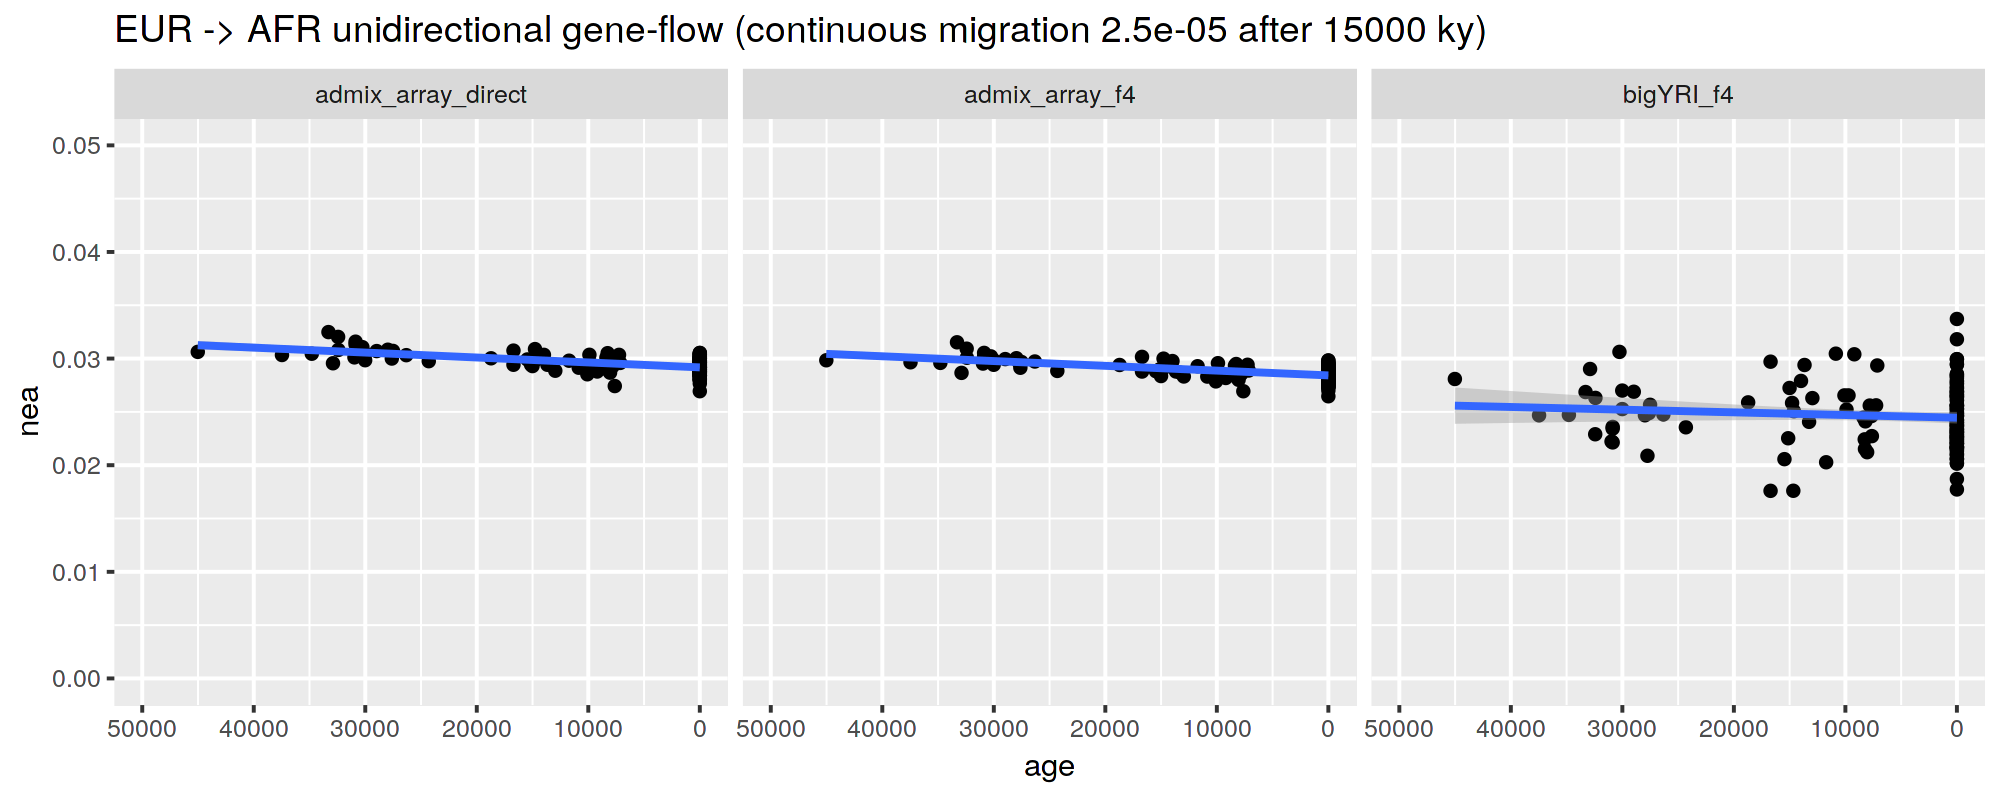

In [32]:
ggplot(nea_est, aes(age, nea)) +
ggtitle(paste("EUR -> AFR unidirectional gene-flow (continuous migration", m_afr_eur, "after", T_m_afr_eur, "ky)")) +
geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm") +
facet_grid(. ~ method)

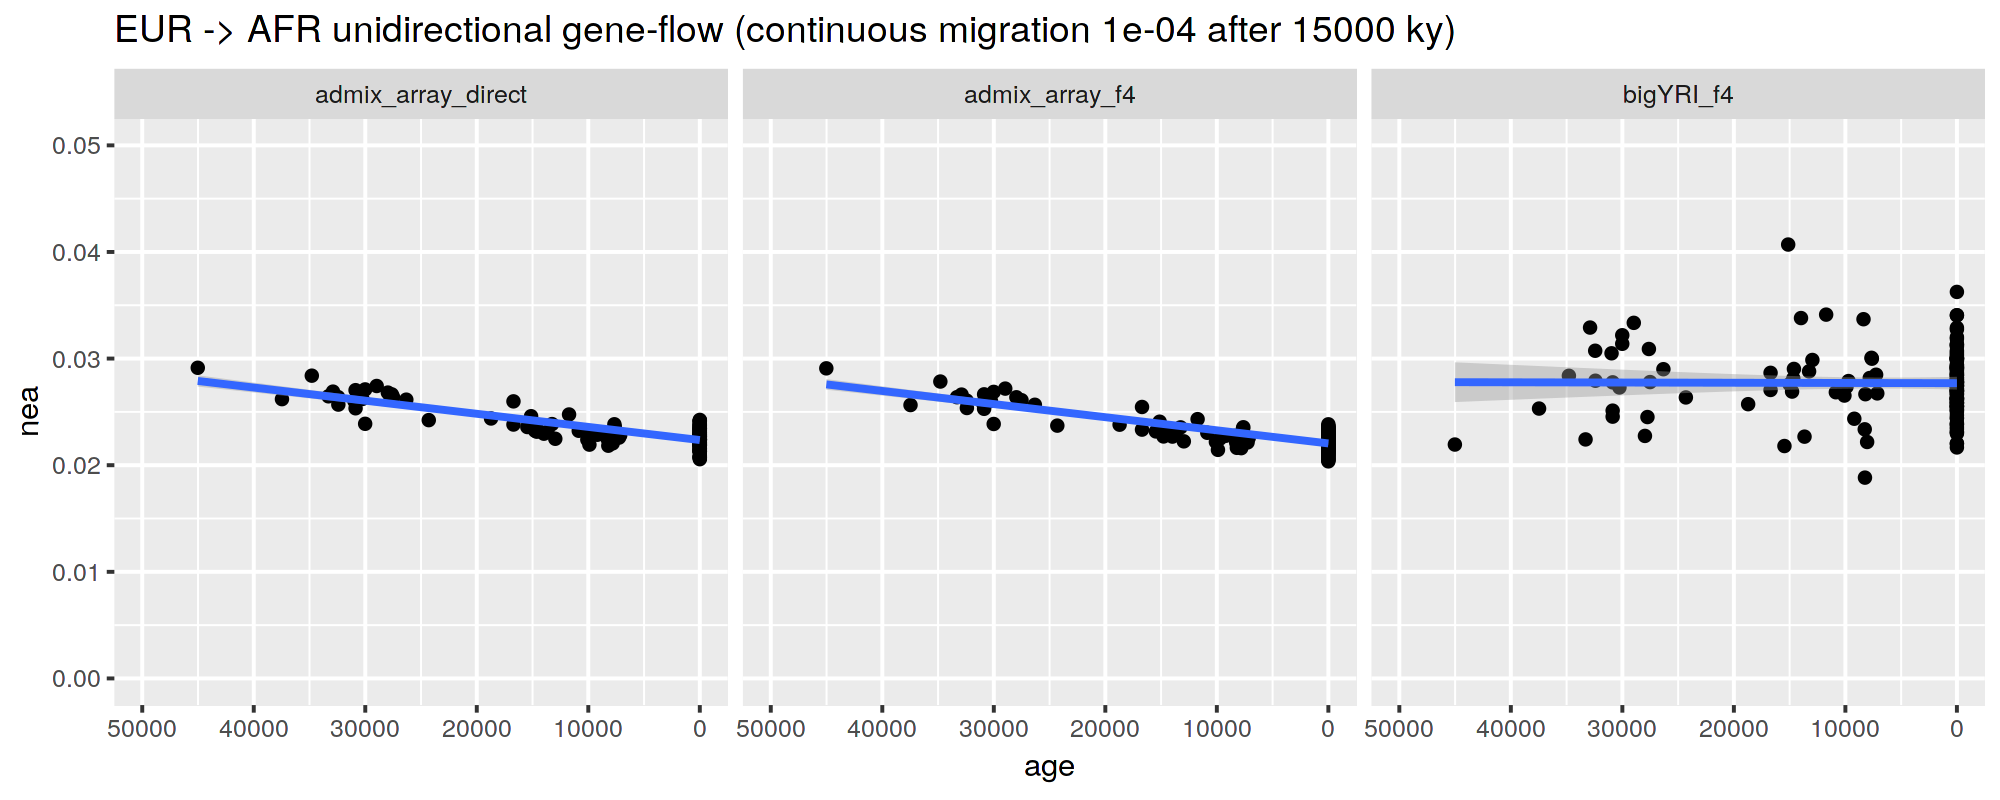

In [32]:
ggplot(nea_est, aes(age, nea)) +
ggtitle(paste("EUR -> AFR unidirectional gene-flow (continuous migration", m_afr_eur, "after", T_m_afr_eur, "ky)")) +
geom_point() + xlim(50000, 0) + ylim(0, 0.05) + geom_smooth(method="lm") +
facet_grid(. ~ method)